# In preparation ...

In [1]:
%%capture
import tensorflow as tf

just for downloading the some data in place of your data.

In [2]:
%%capture
from kgcnn.data.datasets.ESOLDataset import ESOLDataset
ESOLDataset()

move the data from "~/.kgcnn.datasets.esol" to your local "esol" folder. The ESOL data is just some example data for this notebook.

In [3]:
from kgcnn.data.moleculenet import MoleculeNetDataset

In [4]:
data = MoleculeNetDataset(
    data_directory="esol/",
    dataset_name="esol",
    file_name="delaney-processed.csv",
)

In [5]:
data.prepare_data(
    overwrite=True,
    smiles_column_name="smiles",
    add_hydrogen=True, 
    sanitize=True,
    make_conformers=True, 
    optimize_conformer=True,
    external_program=None, 
    num_workers=None
);

In [6]:
%%capture
from kgcnn.molecule.encoder import OneHotEncoder
data.read_in_memory(
    nodes = [
        'Symbol', 'TotalDegree', 'FormalCharge', 'NumRadicalElectrons', 'Hybridization',
        'IsAromatic', 'IsInRing', 'TotalNumHs', 'CIPCode', "ChiralityPossible", "ChiralTag"
    ],
    encoder_nodes = {
        'Symbol': OneHotEncoder(
            ['B', 'C', 'N', 'O', 'F', 'Si', 'P', 'S', 'Cl', 'As', 'Se', 'Br', 'Te', 'I', 'At'],
            dtype="str"
        ),
        'Hybridization': OneHotEncoder([2, 3, 4, 5, 6]),
        'TotalDegree': OneHotEncoder([0, 1, 2, 3, 4, 5], add_unknown=False),
        'TotalNumHs': OneHotEncoder([0, 1, 2, 3, 4], add_unknown=False),
        'CIPCode': OneHotEncoder(['R', 'S'], add_unknown=False, dtype='str'),
        "ChiralityPossible": OneHotEncoder(["1"], add_unknown=False, dtype='str'),
    },
    edges = ['BondType', 'IsAromatic', 'IsConjugated', 'IsInRing', 'Stereo'],
    encoder_edges = {
        'BondType': OneHotEncoder([1, 2, 3, 12], add_unknown=False),
        'Stereo': OneHotEncoder([0, 1, 2, 3], add_unknown=False)
    },
    graph=['ExactMolWt', 'NumAtoms'],
    encoder_graph = {},
    add_hydrogen=False,
    make_directed=False,
    has_conformers=True,
    sanitize=True,
    compute_partial_charges=None,
    label_column_name="measured log solubility in mols per litre"
)

In [7]:
from kgcnn.graph.preprocessor import SetRange, SetEdgeIndicesReverse
data.map_list(SetRange(max_distance=5.0, in_place=True));
data.map_list(SetEdgeIndicesReverse(in_place=True));

In [8]:
data[0].keys()

dict_keys(['node_symbol', 'node_number', 'edge_indices', 'edge_number', 'graph_size', 'node_coordinates', 'graph_labels', 'node_attributes', 'edge_attributes', 'graph_attributes', 'range_indices', 'range_attributes', 'edge_indices_reverse'])

In [9]:
data.clean("edge_indices")

array([934])

In [10]:
import numpy as np
labels = np.array(data.obtain_property("graph_labels"))
if len(labels.shape) <= 1:
    labels = np.expand_dims(labels, axis=-1)

In [11]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, random_state=42, shuffle=True)
train_test_indices = [
    [train_index, test_index] for train_index, test_index in kf.split(X=np.zeros((len(data), 1)), y=labels)]

In [12]:
model_config= {
    "class_name": "make_model",
    "module_name": "kgcnn.literature.DMPNN",
    "config": {
        "name": "DMPNN",
        "inputs": [
            {"shape": [None, 41], "name": "node_attributes", "dtype": "float32", "ragged": True},
            {"shape": [None, 11], "name": "edge_attributes", "dtype": "float32", "ragged": True},
            {"shape": [None, 2], "name": "edge_indices", "dtype": "int64", "ragged": True},
            {"shape": [None, 1], "name": "edge_indices_reverse", "dtype": "int64", "ragged": True}
        ],
        "input_embedding": {"node": {"input_dim": 95, "output_dim": 64},
                            "edge": {"input_dim": 5, "output_dim": 64}},
        "pooling_args": {"pooling_method": "sum"},
        "edge_initialize": {"units": 128, "use_bias": True, "activation": "relu"},
        "edge_dense": {"units": 128, "use_bias": True, "activation": "linear"},
        "edge_activation": {"activation": "relu"},
        "node_dense": {"units": 128, "use_bias": True, "activation": "relu"},
        "verbose": 10, "depth": 5,
        "dropout": {"rate": 0.1},
        "output_embedding": "graph",
        "output_mlp": {
            "use_bias": [True, True, False], "units": [64, 32, 1],
            "activation": ["relu", "relu", "linear"]
        }
    }
}

In [13]:
import time
from kgcnn.model.utils import get_model_class
from tensorflow.keras.optimizers import Adam
from kgcnn.training.scheduler import LinearLearningRateScheduler
from kgcnn.literature.DMPNN import make_model
from kgcnn.data.transform.scaler.molecule import QMGraphLabelScaler
from kgcnn.data.transform.scaler.standard import StandardLabelScaler, StandardScaler
from kgcnn.metrics.metrics import ScaledMeanAbsoluteError, ScaledRootMeanSquaredError
from datetime import timedelta

history_list, test_indices_list = [], []
model, hist, x_test, y_test, scaler, atoms_test = None, None, None, None, None, None
splits_done = 0
for i, (train_index, test_index) in enumerate(train_test_indices):
    print("Running training on fold: %s" % i)

    # Make the model for current split using model kwargs from hyperparameter.
    # They are always updated on top of the models default kwargs.
    model = make_model(**model_config["config"])

    # First select training and test graphs from indices, then convert them into tensorflow tensor
    # representation. Which property of the dataset and whether the tensor will be ragged is retrieved from the
    # kwargs of the keras `Input` layers ('name' and 'ragged').
    dataset_train, dataset_test = data[train_index], data[test_index]
    x_train, y_train = dataset_train.tensor(model_config["config"]["inputs"]), labels[train_index]
    x_test, y_test = dataset_test.tensor(model_config["config"]["inputs"]), labels[test_index]
    
    atoms_test = dataset_test.get("node_number")
    atoms_train = dataset_train.get("node_number")
    
    scaler = StandardLabelScaler(with_std=True,with_mean=True, copy=True)
    scaler.fit(y_train, atomic_number=atoms_train)
    y_train = scaler.transform(y_train, atomic_number=atoms_train)
    y_test = scaler.transform(y_test, atomic_number=atoms_test)

    # If scaler was used we add rescaled standard metrics to compile.
    scaler_scale = scaler.get_scaling()
    mae_metric = ScaledMeanAbsoluteError(scaler_scale.shape, name="scaled_mean_absolute_error")
    rms_metric = ScaledRootMeanSquaredError(scaler_scale.shape, name="scaled_root_mean_squared_error")
    if scaler.scale_ is not None:
        mae_metric.set_scale(scaler_scale)
        rms_metric.set_scale(scaler_scale)
    metrics = [mae_metric, rms_metric]

    # Compile model with optimizer and loss
    model.compile(loss="mean_absolute_error", metrics=metrics, optimizer=Adam(lr=5e-04))
    print(model.summary())

    # Start and time training
    start = time.process_time()
    hist = model.fit(x_train, y_train,
                     validation_data=(x_test, y_test),
                     batch_size=32, 
                     epochs=300, 
                     validation_freq=10, 
                     # Change to verbose = 2 to see progress
                     verbose=2,
                     callbacks= [
                         LinearLearningRateScheduler(
                             learning_rate_start=0.001, learning_rate_stop=1e-05, epo_min=100, epo=300)
                     ])
    stop = time.process_time()
    print("Print Time for training: ", str(timedelta(seconds=stop - start)))

    # Get loss from history
    history_list.append(hist)
    test_indices_list.append([train_index, test_index])
    splits_done = splits_done + 1

Running training on fold: 0
Model: "DMPNN"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 node_attributes (InputLayer)   [(None, None, 41)]   0           []                               
                                                                                                  
 optional_input_embedding (Opti  (None, None, 41)    0           ['node_attributes[0][0]']        
 onalInputEmbedding)                                                                              
                                                                                                  
 edge_indices (InputLayer)      [(None, None, 2)]    0           []                               
                                                                                                  
 edge_attributes (InputLayer)   [(None, None, 11)]   0           [

                                                                  'edge_indices[0][0]',           
                                                                  'edge_indices_reverse[0][0]']   
                                                                                                  
 lazy_add_3 (LazyAdd)           (None, None, 128)    0           ['dense_embedding_1[3][0]',      
                                                                  'dense_embedding[0][0]']        
                                                                                                  
 activation_embedding_3 (Activa  (None, None, 128)   0           ['lazy_add_3[0][0]']             
 tionEmbedding)                                                                                   
                                                                                                  
 dropout_embedding_3 (DropoutEm  (None, None, 128)   0           ['activation_embedding_3[0][0]'] 
 bedding) 

C:\Users\patri\anaconda3\envs\gcnn_keras_test\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
C:\Users\patri\anaconda3\envs\gcnn_keras_test\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/DMPNN/pooling_local_edges_5/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/DMPNN/pooling_local_edges_5/Reshape:0", shape=(None, 128), dtype=float32), dense_shape=Tensor("gradient_tape/DMPNN/pooling_local_edges_5/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
C:\Users\patri\anaconda3\envs\gcnn_keras_test\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/DMPNN/

29/29 - 4s - loss: 0.8634 - scaled_mean_absolute_error: 1.7878 - scaled_root_mean_squared_error: 2.7514 - lr: 0.0010 - 4s/epoch - 144ms/step
Epoch 2/300
29/29 - 0s - loss: 0.5718 - scaled_mean_absolute_error: 1.1839 - scaled_root_mean_squared_error: 1.5287 - lr: 0.0010 - 484ms/epoch - 17ms/step
Epoch 3/300
29/29 - 1s - loss: 0.5179 - scaled_mean_absolute_error: 1.0723 - scaled_root_mean_squared_error: 1.3674 - lr: 0.0010 - 514ms/epoch - 18ms/step
Epoch 4/300
29/29 - 0s - loss: 0.5158 - scaled_mean_absolute_error: 1.0681 - scaled_root_mean_squared_error: 1.3888 - lr: 0.0010 - 490ms/epoch - 17ms/step
Epoch 5/300
29/29 - 0s - loss: 0.4573 - scaled_mean_absolute_error: 0.9469 - scaled_root_mean_squared_error: 1.2153 - lr: 0.0010 - 495ms/epoch - 17ms/step
Epoch 6/300
29/29 - 0s - loss: 0.3822 - scaled_mean_absolute_error: 0.7913 - scaled_root_mean_squared_error: 1.0371 - lr: 0.0010 - 463ms/epoch - 16ms/step
Epoch 7/300
29/29 - 0s - loss: 0.3503 - scaled_mean_absolute_error: 0.7253 - scaled_

Epoch 51/300
29/29 - 0s - loss: 0.1637 - scaled_mean_absolute_error: 0.3389 - scaled_root_mean_squared_error: 0.4923 - lr: 0.0010 - 455ms/epoch - 16ms/step
Epoch 52/300
29/29 - 0s - loss: 0.1863 - scaled_mean_absolute_error: 0.3858 - scaled_root_mean_squared_error: 0.5332 - lr: 0.0010 - 462ms/epoch - 16ms/step
Epoch 53/300
29/29 - 0s - loss: 0.1932 - scaled_mean_absolute_error: 0.4000 - scaled_root_mean_squared_error: 0.5524 - lr: 0.0010 - 457ms/epoch - 16ms/step
Epoch 54/300
29/29 - 0s - loss: 0.1799 - scaled_mean_absolute_error: 0.3725 - scaled_root_mean_squared_error: 0.5251 - lr: 0.0010 - 451ms/epoch - 16ms/step
Epoch 55/300
29/29 - 0s - loss: 0.1814 - scaled_mean_absolute_error: 0.3756 - scaled_root_mean_squared_error: 0.5208 - lr: 0.0010 - 450ms/epoch - 16ms/step
Epoch 56/300
29/29 - 0s - loss: 0.1596 - scaled_mean_absolute_error: 0.3304 - scaled_root_mean_squared_error: 0.4630 - lr: 0.0010 - 457ms/epoch - 16ms/step
Epoch 57/300
29/29 - 0s - loss: 0.1604 - scaled_mean_absolute_er

Epoch 101/300
29/29 - 0s - loss: 0.1221 - scaled_mean_absolute_error: 0.2529 - scaled_root_mean_squared_error: 0.3577 - lr: 0.0010 - 452ms/epoch - 16ms/step
Epoch 102/300
29/29 - 0s - loss: 0.1418 - scaled_mean_absolute_error: 0.2937 - scaled_root_mean_squared_error: 0.4251 - lr: 9.9505e-04 - 449ms/epoch - 15ms/step
Epoch 103/300
29/29 - 0s - loss: 0.1483 - scaled_mean_absolute_error: 0.3070 - scaled_root_mean_squared_error: 0.4109 - lr: 9.9010e-04 - 454ms/epoch - 16ms/step
Epoch 104/300
29/29 - 0s - loss: 0.1353 - scaled_mean_absolute_error: 0.2802 - scaled_root_mean_squared_error: 0.3853 - lr: 9.8515e-04 - 466ms/epoch - 16ms/step
Epoch 105/300
29/29 - 0s - loss: 0.1247 - scaled_mean_absolute_error: 0.2582 - scaled_root_mean_squared_error: 0.3590 - lr: 9.8020e-04 - 482ms/epoch - 17ms/step
Epoch 106/300
29/29 - 0s - loss: 0.1316 - scaled_mean_absolute_error: 0.2724 - scaled_root_mean_squared_error: 0.3888 - lr: 9.7525e-04 - 456ms/epoch - 16ms/step
Epoch 107/300
29/29 - 0s - loss: 0.129

Epoch 150/300
29/29 - 1s - loss: 0.0984 - scaled_mean_absolute_error: 0.2037 - scaled_root_mean_squared_error: 0.2824 - val_loss: 0.2163 - val_scaled_mean_absolute_error: 0.4480 - val_scaled_root_mean_squared_error: 0.6672 - lr: 7.5745e-04 - 595ms/epoch - 21ms/step
Epoch 151/300
29/29 - 1s - loss: 0.1009 - scaled_mean_absolute_error: 0.2089 - scaled_root_mean_squared_error: 0.2921 - lr: 7.5250e-04 - 515ms/epoch - 18ms/step
Epoch 152/300
29/29 - 1s - loss: 0.0996 - scaled_mean_absolute_error: 0.2063 - scaled_root_mean_squared_error: 0.2903 - lr: 7.4755e-04 - 512ms/epoch - 18ms/step
Epoch 153/300
29/29 - 0s - loss: 0.0996 - scaled_mean_absolute_error: 0.2062 - scaled_root_mean_squared_error: 0.2862 - lr: 7.4260e-04 - 487ms/epoch - 17ms/step
Epoch 154/300
29/29 - 1s - loss: 0.0962 - scaled_mean_absolute_error: 0.1992 - scaled_root_mean_squared_error: 0.2758 - lr: 7.3765e-04 - 505ms/epoch - 17ms/step
Epoch 155/300
29/29 - 0s - loss: 0.0939 - scaled_mean_absolute_error: 0.1945 - scaled_root

Epoch 198/300
29/29 - 0s - loss: 0.0783 - scaled_mean_absolute_error: 0.1622 - scaled_root_mean_squared_error: 0.2260 - lr: 5.1985e-04 - 471ms/epoch - 16ms/step
Epoch 199/300
29/29 - 0s - loss: 0.0780 - scaled_mean_absolute_error: 0.1616 - scaled_root_mean_squared_error: 0.2235 - lr: 5.1490e-04 - 492ms/epoch - 17ms/step
Epoch 200/300
29/29 - 1s - loss: 0.0815 - scaled_mean_absolute_error: 0.1687 - scaled_root_mean_squared_error: 0.2440 - val_loss: 0.2243 - val_scaled_mean_absolute_error: 0.4644 - val_scaled_root_mean_squared_error: 0.6802 - lr: 5.0995e-04 - 595ms/epoch - 21ms/step
Epoch 201/300
29/29 - 0s - loss: 0.0875 - scaled_mean_absolute_error: 0.1812 - scaled_root_mean_squared_error: 0.2537 - lr: 5.0500e-04 - 474ms/epoch - 16ms/step
Epoch 202/300
29/29 - 0s - loss: 0.0811 - scaled_mean_absolute_error: 0.1680 - scaled_root_mean_squared_error: 0.2328 - lr: 5.0005e-04 - 478ms/epoch - 16ms/step
Epoch 203/300
29/29 - 0s - loss: 0.0817 - scaled_mean_absolute_error: 0.1693 - scaled_root

Epoch 246/300
29/29 - 1s - loss: 0.0652 - scaled_mean_absolute_error: 0.1350 - scaled_root_mean_squared_error: 0.1965 - lr: 2.8225e-04 - 519ms/epoch - 18ms/step
Epoch 247/300
29/29 - 1s - loss: 0.0640 - scaled_mean_absolute_error: 0.1324 - scaled_root_mean_squared_error: 0.1927 - lr: 2.7730e-04 - 524ms/epoch - 18ms/step
Epoch 248/300
29/29 - 0s - loss: 0.0663 - scaled_mean_absolute_error: 0.1374 - scaled_root_mean_squared_error: 0.1973 - lr: 2.7235e-04 - 458ms/epoch - 16ms/step
Epoch 249/300
29/29 - 0s - loss: 0.0636 - scaled_mean_absolute_error: 0.1317 - scaled_root_mean_squared_error: 0.1893 - lr: 2.6740e-04 - 492ms/epoch - 17ms/step
Epoch 250/300
29/29 - 1s - loss: 0.0686 - scaled_mean_absolute_error: 0.1420 - scaled_root_mean_squared_error: 0.2063 - val_loss: 0.2178 - val_scaled_mean_absolute_error: 0.4510 - val_scaled_root_mean_squared_error: 0.6630 - lr: 2.6245e-04 - 551ms/epoch - 19ms/step
Epoch 251/300
29/29 - 0s - loss: 0.0648 - scaled_mean_absolute_error: 0.1341 - scaled_root

Epoch 294/300
29/29 - 0s - loss: 0.0514 - scaled_mean_absolute_error: 0.1064 - scaled_root_mean_squared_error: 0.1651 - lr: 4.4650e-05 - 456ms/epoch - 16ms/step
Epoch 295/300
29/29 - 0s - loss: 0.0533 - scaled_mean_absolute_error: 0.1104 - scaled_root_mean_squared_error: 0.1721 - lr: 3.9700e-05 - 451ms/epoch - 16ms/step
Epoch 296/300
29/29 - 0s - loss: 0.0546 - scaled_mean_absolute_error: 0.1130 - scaled_root_mean_squared_error: 0.1743 - lr: 3.4750e-05 - 452ms/epoch - 16ms/step
Epoch 297/300
29/29 - 0s - loss: 0.0514 - scaled_mean_absolute_error: 0.1065 - scaled_root_mean_squared_error: 0.1651 - lr: 2.9800e-05 - 454ms/epoch - 16ms/step
Epoch 298/300
29/29 - 0s - loss: 0.0529 - scaled_mean_absolute_error: 0.1096 - scaled_root_mean_squared_error: 0.1657 - lr: 2.4850e-05 - 453ms/epoch - 16ms/step
Epoch 299/300
29/29 - 1s - loss: 0.0510 - scaled_mean_absolute_error: 0.1056 - scaled_root_mean_squared_error: 0.1600 - lr: 1.9900e-05 - 508ms/epoch - 18ms/step
Epoch 300/300
29/29 - 1s - loss: 0

 dmpnnp_pooling_edges_directed_  (None, None, 128)   0           ['optional_input_embedding_2[0][0
 7 (DMPNNPPoolingEdgesDirected)                                  ]',                              
                                                                  'dropout_embedding_6[0][0]',    
                                                                  'edge_indices[0][0]',           
                                                                  'edge_indices_reverse[0][0]']   
                                                                                                  
 lazy_add_7 (LazyAdd)           (None, None, 128)    0           ['dense_embedding_4[2][0]',      
                                                                  'dense_embedding_3[0][0]']      
                                                                                                  
 activation_embedding_7 (Activa  (None, None, 128)   0           ['lazy_add_7[0][0]']             
 tionEmbed

C:\Users\patri\anaconda3\envs\gcnn_keras_test\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
C:\Users\patri\anaconda3\envs\gcnn_keras_test\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/DMPNN/pooling_local_edges_11/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/DMPNN/pooling_local_edges_11/Reshape:0", shape=(None, 128), dtype=float32), dense_shape=Tensor("gradient_tape/DMPNN/pooling_local_edges_11/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
C:\Users\patri\anaconda3\envs\gcnn_keras_test\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/DMP

29/29 - 4s - loss: 1.3492 - scaled_mean_absolute_error: 2.8441 - scaled_root_mean_squared_error: 7.2500 - lr: 0.0010 - 4s/epoch - 125ms/step
Epoch 2/300
29/29 - 1s - loss: 0.6681 - scaled_mean_absolute_error: 1.4084 - scaled_root_mean_squared_error: 2.2246 - lr: 0.0010 - 518ms/epoch - 18ms/step
Epoch 3/300
29/29 - 1s - loss: 0.5780 - scaled_mean_absolute_error: 1.2183 - scaled_root_mean_squared_error: 1.6904 - lr: 0.0010 - 517ms/epoch - 18ms/step
Epoch 4/300
29/29 - 1s - loss: 0.4807 - scaled_mean_absolute_error: 1.0132 - scaled_root_mean_squared_error: 1.3366 - lr: 0.0010 - 514ms/epoch - 18ms/step
Epoch 5/300
29/29 - 0s - loss: 0.4943 - scaled_mean_absolute_error: 1.0421 - scaled_root_mean_squared_error: 1.4151 - lr: 0.0010 - 450ms/epoch - 16ms/step
Epoch 6/300
29/29 - 0s - loss: 0.4532 - scaled_mean_absolute_error: 0.9553 - scaled_root_mean_squared_error: 1.3190 - lr: 0.0010 - 483ms/epoch - 17ms/step
Epoch 7/300
29/29 - 0s - loss: 0.4008 - scaled_mean_absolute_error: 0.8449 - scaled_

Epoch 51/300
29/29 - 0s - loss: 0.1856 - scaled_mean_absolute_error: 0.3912 - scaled_root_mean_squared_error: 0.5633 - lr: 0.0010 - 489ms/epoch - 17ms/step
Epoch 52/300
29/29 - 0s - loss: 0.1843 - scaled_mean_absolute_error: 0.3886 - scaled_root_mean_squared_error: 0.5422 - lr: 0.0010 - 497ms/epoch - 17ms/step
Epoch 53/300
29/29 - 1s - loss: 0.1662 - scaled_mean_absolute_error: 0.3503 - scaled_root_mean_squared_error: 0.4984 - lr: 0.0010 - 528ms/epoch - 18ms/step
Epoch 54/300
29/29 - 1s - loss: 0.1676 - scaled_mean_absolute_error: 0.3533 - scaled_root_mean_squared_error: 0.5015 - lr: 0.0010 - 514ms/epoch - 18ms/step
Epoch 55/300
29/29 - 0s - loss: 0.1780 - scaled_mean_absolute_error: 0.3753 - scaled_root_mean_squared_error: 0.5430 - lr: 0.0010 - 469ms/epoch - 16ms/step
Epoch 56/300
29/29 - 0s - loss: 0.1867 - scaled_mean_absolute_error: 0.3935 - scaled_root_mean_squared_error: 0.5599 - lr: 0.0010 - 478ms/epoch - 16ms/step
Epoch 57/300
29/29 - 0s - loss: 0.1670 - scaled_mean_absolute_er

Epoch 101/300
29/29 - 0s - loss: 0.1310 - scaled_mean_absolute_error: 0.2761 - scaled_root_mean_squared_error: 0.3986 - lr: 0.0010 - 472ms/epoch - 16ms/step
Epoch 102/300
29/29 - 0s - loss: 0.1433 - scaled_mean_absolute_error: 0.3020 - scaled_root_mean_squared_error: 0.4471 - lr: 9.9505e-04 - 466ms/epoch - 16ms/step
Epoch 103/300
29/29 - 0s - loss: 0.1559 - scaled_mean_absolute_error: 0.3287 - scaled_root_mean_squared_error: 0.4698 - lr: 9.9010e-04 - 463ms/epoch - 16ms/step
Epoch 104/300
29/29 - 0s - loss: 0.1421 - scaled_mean_absolute_error: 0.2996 - scaled_root_mean_squared_error: 0.4380 - lr: 9.8515e-04 - 480ms/epoch - 17ms/step
Epoch 105/300
29/29 - 0s - loss: 0.1607 - scaled_mean_absolute_error: 0.3387 - scaled_root_mean_squared_error: 0.4698 - lr: 9.8020e-04 - 481ms/epoch - 17ms/step
Epoch 106/300
29/29 - 0s - loss: 0.1490 - scaled_mean_absolute_error: 0.3141 - scaled_root_mean_squared_error: 0.4533 - lr: 9.7525e-04 - 484ms/epoch - 17ms/step
Epoch 107/300
29/29 - 0s - loss: 0.127

Epoch 150/300
29/29 - 1s - loss: 0.1057 - scaled_mean_absolute_error: 0.2229 - scaled_root_mean_squared_error: 0.3251 - val_loss: 0.2007 - val_scaled_mean_absolute_error: 0.4231 - val_scaled_root_mean_squared_error: 0.5978 - lr: 7.5745e-04 - 630ms/epoch - 22ms/step
Epoch 151/300
29/29 - 0s - loss: 0.1008 - scaled_mean_absolute_error: 0.2125 - scaled_root_mean_squared_error: 0.3223 - lr: 7.5250e-04 - 496ms/epoch - 17ms/step
Epoch 152/300
29/29 - 1s - loss: 0.0980 - scaled_mean_absolute_error: 0.2065 - scaled_root_mean_squared_error: 0.3187 - lr: 7.4755e-04 - 514ms/epoch - 18ms/step
Epoch 153/300
29/29 - 1s - loss: 0.1085 - scaled_mean_absolute_error: 0.2286 - scaled_root_mean_squared_error: 0.3487 - lr: 7.4260e-04 - 520ms/epoch - 18ms/step
Epoch 154/300
29/29 - 0s - loss: 0.1169 - scaled_mean_absolute_error: 0.2464 - scaled_root_mean_squared_error: 0.3660 - lr: 7.3765e-04 - 489ms/epoch - 17ms/step
Epoch 155/300
29/29 - 1s - loss: 0.1000 - scaled_mean_absolute_error: 0.2108 - scaled_root

Epoch 198/300
29/29 - 0s - loss: 0.0787 - scaled_mean_absolute_error: 0.1660 - scaled_root_mean_squared_error: 0.2401 - lr: 5.1985e-04 - 448ms/epoch - 15ms/step
Epoch 199/300
29/29 - 0s - loss: 0.0774 - scaled_mean_absolute_error: 0.1631 - scaled_root_mean_squared_error: 0.2457 - lr: 5.1490e-04 - 455ms/epoch - 16ms/step
Epoch 200/300
29/29 - 1s - loss: 0.0762 - scaled_mean_absolute_error: 0.1606 - scaled_root_mean_squared_error: 0.2324 - val_loss: 0.2045 - val_scaled_mean_absolute_error: 0.4310 - val_scaled_root_mean_squared_error: 0.6240 - lr: 5.0995e-04 - 542ms/epoch - 19ms/step
Epoch 201/300
29/29 - 0s - loss: 0.0792 - scaled_mean_absolute_error: 0.1669 - scaled_root_mean_squared_error: 0.2390 - lr: 5.0500e-04 - 450ms/epoch - 16ms/step
Epoch 202/300
29/29 - 0s - loss: 0.0766 - scaled_mean_absolute_error: 0.1615 - scaled_root_mean_squared_error: 0.2360 - lr: 5.0005e-04 - 448ms/epoch - 15ms/step
Epoch 203/300
29/29 - 0s - loss: 0.0805 - scaled_mean_absolute_error: 0.1697 - scaled_root

Epoch 246/300
29/29 - 0s - loss: 0.0680 - scaled_mean_absolute_error: 0.1434 - scaled_root_mean_squared_error: 0.2099 - lr: 2.8225e-04 - 459ms/epoch - 16ms/step
Epoch 247/300
29/29 - 0s - loss: 0.0626 - scaled_mean_absolute_error: 0.1319 - scaled_root_mean_squared_error: 0.1926 - lr: 2.7730e-04 - 485ms/epoch - 17ms/step
Epoch 248/300
29/29 - 0s - loss: 0.0633 - scaled_mean_absolute_error: 0.1333 - scaled_root_mean_squared_error: 0.1997 - lr: 2.7235e-04 - 489ms/epoch - 17ms/step
Epoch 249/300
29/29 - 0s - loss: 0.0652 - scaled_mean_absolute_error: 0.1375 - scaled_root_mean_squared_error: 0.2043 - lr: 2.6740e-04 - 477ms/epoch - 16ms/step
Epoch 250/300
29/29 - 1s - loss: 0.0649 - scaled_mean_absolute_error: 0.1367 - scaled_root_mean_squared_error: 0.2072 - val_loss: 0.2061 - val_scaled_mean_absolute_error: 0.4344 - val_scaled_root_mean_squared_error: 0.6229 - lr: 2.6245e-04 - 595ms/epoch - 21ms/step
Epoch 251/300
29/29 - 1s - loss: 0.0678 - scaled_mean_absolute_error: 0.1429 - scaled_root

Epoch 294/300
29/29 - 0s - loss: 0.0511 - scaled_mean_absolute_error: 0.1078 - scaled_root_mean_squared_error: 0.1657 - lr: 4.4650e-05 - 452ms/epoch - 16ms/step
Epoch 295/300
29/29 - 0s - loss: 0.0530 - scaled_mean_absolute_error: 0.1117 - scaled_root_mean_squared_error: 0.1727 - lr: 3.9700e-05 - 448ms/epoch - 15ms/step
Epoch 296/300
29/29 - 0s - loss: 0.0495 - scaled_mean_absolute_error: 0.1044 - scaled_root_mean_squared_error: 0.1637 - lr: 3.4750e-05 - 451ms/epoch - 16ms/step
Epoch 297/300
29/29 - 0s - loss: 0.0514 - scaled_mean_absolute_error: 0.1084 - scaled_root_mean_squared_error: 0.1677 - lr: 2.9800e-05 - 453ms/epoch - 16ms/step
Epoch 298/300
29/29 - 0s - loss: 0.0494 - scaled_mean_absolute_error: 0.1042 - scaled_root_mean_squared_error: 0.1598 - lr: 2.4850e-05 - 448ms/epoch - 15ms/step
Epoch 299/300
29/29 - 0s - loss: 0.0520 - scaled_mean_absolute_error: 0.1095 - scaled_root_mean_squared_error: 0.1677 - lr: 1.9900e-05 - 453ms/epoch - 16ms/step
Epoch 300/300
29/29 - 1s - loss: 0

 dmpnnp_pooling_edges_directed_  (None, None, 128)   0           ['optional_input_embedding_4[0][0
 12 (DMPNNPPoolingEdgesDirected                                  ]',                              
 )                                                                'dropout_embedding_11[0][0]',   
                                                                  'edge_indices[0][0]',           
                                                                  'edge_indices_reverse[0][0]']   
                                                                                                  
 lazy_add_12 (LazyAdd)          (None, None, 128)    0           ['dense_embedding_7[2][0]',      
                                                                  'dense_embedding_6[0][0]']      
                                                                                                  
 activation_embedding_12 (Activ  (None, None, 128)   0           ['lazy_add_12[0][0]']            
 ationEmbe

C:\Users\patri\anaconda3\envs\gcnn_keras_test\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
C:\Users\patri\anaconda3\envs\gcnn_keras_test\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/DMPNN/pooling_local_edges_17/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/DMPNN/pooling_local_edges_17/Reshape:0", shape=(None, 128), dtype=float32), dense_shape=Tensor("gradient_tape/DMPNN/pooling_local_edges_17/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
C:\Users\patri\anaconda3\envs\gcnn_keras_test\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/DMP

29/29 - 3s - loss: 1.5364 - scaled_mean_absolute_error: 3.2581 - scaled_root_mean_squared_error: 7.1084 - lr: 0.0010 - 3s/epoch - 118ms/step
Epoch 2/300
29/29 - 0s - loss: 0.5889 - scaled_mean_absolute_error: 1.2488 - scaled_root_mean_squared_error: 1.6422 - lr: 0.0010 - 450ms/epoch - 16ms/step
Epoch 3/300
29/29 - 0s - loss: 0.6294 - scaled_mean_absolute_error: 1.3348 - scaled_root_mean_squared_error: 1.7305 - lr: 0.0010 - 451ms/epoch - 16ms/step
Epoch 4/300
29/29 - 0s - loss: 0.4576 - scaled_mean_absolute_error: 0.9704 - scaled_root_mean_squared_error: 1.2442 - lr: 0.0010 - 453ms/epoch - 16ms/step
Epoch 5/300
29/29 - 0s - loss: 0.4174 - scaled_mean_absolute_error: 0.8852 - scaled_root_mean_squared_error: 1.1342 - lr: 0.0010 - 451ms/epoch - 16ms/step
Epoch 6/300
29/29 - 0s - loss: 0.4192 - scaled_mean_absolute_error: 0.8889 - scaled_root_mean_squared_error: 1.1559 - lr: 0.0010 - 454ms/epoch - 16ms/step
Epoch 7/300
29/29 - 0s - loss: 0.3790 - scaled_mean_absolute_error: 0.8037 - scaled_

Epoch 51/300
29/29 - 0s - loss: 0.1815 - scaled_mean_absolute_error: 0.3849 - scaled_root_mean_squared_error: 0.5250 - lr: 0.0010 - 458ms/epoch - 16ms/step
Epoch 52/300
29/29 - 0s - loss: 0.1831 - scaled_mean_absolute_error: 0.3882 - scaled_root_mean_squared_error: 0.5210 - lr: 0.0010 - 454ms/epoch - 16ms/step
Epoch 53/300
29/29 - 0s - loss: 0.1838 - scaled_mean_absolute_error: 0.3897 - scaled_root_mean_squared_error: 0.5326 - lr: 0.0010 - 446ms/epoch - 15ms/step
Epoch 54/300
29/29 - 0s - loss: 0.1828 - scaled_mean_absolute_error: 0.3876 - scaled_root_mean_squared_error: 0.5270 - lr: 0.0010 - 456ms/epoch - 16ms/step
Epoch 55/300
29/29 - 1s - loss: 0.1873 - scaled_mean_absolute_error: 0.3972 - scaled_root_mean_squared_error: 0.5370 - lr: 0.0010 - 512ms/epoch - 18ms/step
Epoch 56/300
29/29 - 1s - loss: 0.1924 - scaled_mean_absolute_error: 0.4081 - scaled_root_mean_squared_error: 0.5645 - lr: 0.0010 - 511ms/epoch - 18ms/step
Epoch 57/300
29/29 - 1s - loss: 0.2092 - scaled_mean_absolute_er

Epoch 101/300
29/29 - 0s - loss: 0.1354 - scaled_mean_absolute_error: 0.2871 - scaled_root_mean_squared_error: 0.3907 - lr: 0.0010 - 450ms/epoch - 16ms/step
Epoch 102/300
29/29 - 0s - loss: 0.1343 - scaled_mean_absolute_error: 0.2848 - scaled_root_mean_squared_error: 0.3987 - lr: 9.9505e-04 - 452ms/epoch - 16ms/step
Epoch 103/300
29/29 - 0s - loss: 0.1366 - scaled_mean_absolute_error: 0.2896 - scaled_root_mean_squared_error: 0.4034 - lr: 9.9010e-04 - 457ms/epoch - 16ms/step
Epoch 104/300
29/29 - 0s - loss: 0.1298 - scaled_mean_absolute_error: 0.2754 - scaled_root_mean_squared_error: 0.3851 - lr: 9.8515e-04 - 459ms/epoch - 16ms/step
Epoch 105/300
29/29 - 0s - loss: 0.1323 - scaled_mean_absolute_error: 0.2806 - scaled_root_mean_squared_error: 0.3884 - lr: 9.8020e-04 - 464ms/epoch - 16ms/step
Epoch 106/300
29/29 - 0s - loss: 0.1317 - scaled_mean_absolute_error: 0.2792 - scaled_root_mean_squared_error: 0.3892 - lr: 9.7525e-04 - 452ms/epoch - 16ms/step
Epoch 107/300
29/29 - 0s - loss: 0.144

Epoch 150/300
29/29 - 1s - loss: 0.1089 - scaled_mean_absolute_error: 0.2309 - scaled_root_mean_squared_error: 0.3227 - val_loss: 0.1955 - val_scaled_mean_absolute_error: 0.4146 - val_scaled_root_mean_squared_error: 0.6136 - lr: 7.5745e-04 - 551ms/epoch - 19ms/step
Epoch 151/300
29/29 - 0s - loss: 0.1024 - scaled_mean_absolute_error: 0.2172 - scaled_root_mean_squared_error: 0.3057 - lr: 7.5250e-04 - 470ms/epoch - 16ms/step
Epoch 152/300
29/29 - 1s - loss: 0.0950 - scaled_mean_absolute_error: 0.2014 - scaled_root_mean_squared_error: 0.2930 - lr: 7.4755e-04 - 515ms/epoch - 18ms/step
Epoch 153/300
29/29 - 1s - loss: 0.1051 - scaled_mean_absolute_error: 0.2229 - scaled_root_mean_squared_error: 0.3220 - lr: 7.4260e-04 - 511ms/epoch - 18ms/step
Epoch 154/300
29/29 - 1s - loss: 0.1006 - scaled_mean_absolute_error: 0.2134 - scaled_root_mean_squared_error: 0.3112 - lr: 7.3765e-04 - 508ms/epoch - 18ms/step
Epoch 155/300
29/29 - 0s - loss: 0.0995 - scaled_mean_absolute_error: 0.2110 - scaled_root

Epoch 198/300
29/29 - 0s - loss: 0.0894 - scaled_mean_absolute_error: 0.1895 - scaled_root_mean_squared_error: 0.2672 - lr: 5.1985e-04 - 454ms/epoch - 16ms/step
Epoch 199/300
29/29 - 0s - loss: 0.0810 - scaled_mean_absolute_error: 0.1717 - scaled_root_mean_squared_error: 0.2525 - lr: 5.1490e-04 - 464ms/epoch - 16ms/step
Epoch 200/300
29/29 - 1s - loss: 0.0811 - scaled_mean_absolute_error: 0.1719 - scaled_root_mean_squared_error: 0.2535 - val_loss: 0.1960 - val_scaled_mean_absolute_error: 0.4155 - val_scaled_root_mean_squared_error: 0.5933 - lr: 5.0995e-04 - 552ms/epoch - 19ms/step
Epoch 201/300
29/29 - 0s - loss: 0.0800 - scaled_mean_absolute_error: 0.1697 - scaled_root_mean_squared_error: 0.2471 - lr: 5.0500e-04 - 449ms/epoch - 15ms/step
Epoch 202/300
29/29 - 0s - loss: 0.0791 - scaled_mean_absolute_error: 0.1677 - scaled_root_mean_squared_error: 0.2422 - lr: 5.0005e-04 - 456ms/epoch - 16ms/step
Epoch 203/300
29/29 - 0s - loss: 0.0833 - scaled_mean_absolute_error: 0.1767 - scaled_root

Epoch 246/300
29/29 - 0s - loss: 0.0692 - scaled_mean_absolute_error: 0.1467 - scaled_root_mean_squared_error: 0.2172 - lr: 2.8225e-04 - 449ms/epoch - 15ms/step
Epoch 247/300
29/29 - 0s - loss: 0.0704 - scaled_mean_absolute_error: 0.1492 - scaled_root_mean_squared_error: 0.2229 - lr: 2.7730e-04 - 452ms/epoch - 16ms/step
Epoch 248/300
29/29 - 0s - loss: 0.0711 - scaled_mean_absolute_error: 0.1508 - scaled_root_mean_squared_error: 0.2200 - lr: 2.7235e-04 - 484ms/epoch - 17ms/step
Epoch 249/300
29/29 - 1s - loss: 0.0722 - scaled_mean_absolute_error: 0.1530 - scaled_root_mean_squared_error: 0.2205 - lr: 2.6740e-04 - 503ms/epoch - 17ms/step
Epoch 250/300
29/29 - 1s - loss: 0.0709 - scaled_mean_absolute_error: 0.1504 - scaled_root_mean_squared_error: 0.2219 - val_loss: 0.1899 - val_scaled_mean_absolute_error: 0.4028 - val_scaled_root_mean_squared_error: 0.5869 - lr: 2.6245e-04 - 642ms/epoch - 22ms/step
Epoch 251/300
29/29 - 1s - loss: 0.0652 - scaled_mean_absolute_error: 0.1382 - scaled_root

Epoch 294/300
29/29 - 0s - loss: 0.0548 - scaled_mean_absolute_error: 0.1162 - scaled_root_mean_squared_error: 0.1822 - lr: 4.4650e-05 - 485ms/epoch - 17ms/step
Epoch 295/300
29/29 - 0s - loss: 0.0541 - scaled_mean_absolute_error: 0.1147 - scaled_root_mean_squared_error: 0.1772 - lr: 3.9700e-05 - 473ms/epoch - 16ms/step
Epoch 296/300
29/29 - 0s - loss: 0.0552 - scaled_mean_absolute_error: 0.1170 - scaled_root_mean_squared_error: 0.1850 - lr: 3.4750e-05 - 450ms/epoch - 16ms/step
Epoch 297/300
29/29 - 1s - loss: 0.0559 - scaled_mean_absolute_error: 0.1185 - scaled_root_mean_squared_error: 0.1827 - lr: 2.9800e-05 - 510ms/epoch - 18ms/step
Epoch 298/300
29/29 - 0s - loss: 0.0537 - scaled_mean_absolute_error: 0.1139 - scaled_root_mean_squared_error: 0.1800 - lr: 2.4850e-05 - 462ms/epoch - 16ms/step
Epoch 299/300
29/29 - 1s - loss: 0.0560 - scaled_mean_absolute_error: 0.1187 - scaled_root_mean_squared_error: 0.1853 - lr: 1.9900e-05 - 509ms/epoch - 18ms/step
Epoch 300/300
29/29 - 1s - loss: 0

 dmpnnp_pooling_edges_directed_  (None, None, 128)   0           ['optional_input_embedding_6[0][0
 17 (DMPNNPPoolingEdgesDirected                                  ]',                              
 )                                                                'dropout_embedding_16[0][0]',   
                                                                  'edge_indices[0][0]',           
                                                                  'edge_indices_reverse[0][0]']   
                                                                                                  
 lazy_add_17 (LazyAdd)          (None, None, 128)    0           ['dense_embedding_10[2][0]',     
                                                                  'dense_embedding_9[0][0]']      
                                                                                                  
 activation_embedding_17 (Activ  (None, None, 128)   0           ['lazy_add_17[0][0]']            
 ationEmbe

C:\Users\patri\anaconda3\envs\gcnn_keras_test\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
C:\Users\patri\anaconda3\envs\gcnn_keras_test\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/DMPNN/pooling_local_edges_23/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/DMPNN/pooling_local_edges_23/Reshape:0", shape=(None, 128), dtype=float32), dense_shape=Tensor("gradient_tape/DMPNN/pooling_local_edges_23/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
C:\Users\patri\anaconda3\envs\gcnn_keras_test\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/DMP

29/29 - 4s - loss: 1.0422 - scaled_mean_absolute_error: 2.1636 - scaled_root_mean_squared_error: 3.7669 - lr: 0.0010 - 4s/epoch - 151ms/step
Epoch 2/300
29/29 - 0s - loss: 0.5515 - scaled_mean_absolute_error: 1.1448 - scaled_root_mean_squared_error: 1.4999 - lr: 0.0010 - 479ms/epoch - 17ms/step
Epoch 3/300
29/29 - 0s - loss: 0.5012 - scaled_mean_absolute_error: 1.0404 - scaled_root_mean_squared_error: 1.3211 - lr: 0.0010 - 498ms/epoch - 17ms/step
Epoch 4/300
29/29 - 0s - loss: 0.4684 - scaled_mean_absolute_error: 0.9724 - scaled_root_mean_squared_error: 1.2595 - lr: 0.0010 - 476ms/epoch - 16ms/step
Epoch 5/300
29/29 - 1s - loss: 0.4014 - scaled_mean_absolute_error: 0.8333 - scaled_root_mean_squared_error: 1.0750 - lr: 0.0010 - 507ms/epoch - 17ms/step
Epoch 6/300
29/29 - 1s - loss: 0.4017 - scaled_mean_absolute_error: 0.8338 - scaled_root_mean_squared_error: 1.0660 - lr: 0.0010 - 518ms/epoch - 18ms/step
Epoch 7/300
29/29 - 1s - loss: 0.4163 - scaled_mean_absolute_error: 0.8643 - scaled_

Epoch 51/300
29/29 - 0s - loss: 0.1855 - scaled_mean_absolute_error: 0.3850 - scaled_root_mean_squared_error: 0.5411 - lr: 0.0010 - 455ms/epoch - 16ms/step
Epoch 52/300
29/29 - 0s - loss: 0.1729 - scaled_mean_absolute_error: 0.3590 - scaled_root_mean_squared_error: 0.4998 - lr: 0.0010 - 460ms/epoch - 16ms/step
Epoch 53/300
29/29 - 0s - loss: 0.1677 - scaled_mean_absolute_error: 0.3482 - scaled_root_mean_squared_error: 0.4942 - lr: 0.0010 - 465ms/epoch - 16ms/step
Epoch 54/300
29/29 - 0s - loss: 0.1770 - scaled_mean_absolute_error: 0.3675 - scaled_root_mean_squared_error: 0.5134 - lr: 0.0010 - 483ms/epoch - 17ms/step
Epoch 55/300
29/29 - 1s - loss: 0.1811 - scaled_mean_absolute_error: 0.3760 - scaled_root_mean_squared_error: 0.5199 - lr: 0.0010 - 520ms/epoch - 18ms/step
Epoch 56/300
29/29 - 0s - loss: 0.1788 - scaled_mean_absolute_error: 0.3711 - scaled_root_mean_squared_error: 0.5102 - lr: 0.0010 - 475ms/epoch - 16ms/step
Epoch 57/300
29/29 - 0s - loss: 0.1816 - scaled_mean_absolute_er

Epoch 101/300
29/29 - 0s - loss: 0.1310 - scaled_mean_absolute_error: 0.2719 - scaled_root_mean_squared_error: 0.3836 - lr: 0.0010 - 487ms/epoch - 17ms/step
Epoch 102/300
29/29 - 0s - loss: 0.1353 - scaled_mean_absolute_error: 0.2808 - scaled_root_mean_squared_error: 0.3921 - lr: 9.9505e-04 - 457ms/epoch - 16ms/step
Epoch 103/300
29/29 - 0s - loss: 0.1372 - scaled_mean_absolute_error: 0.2848 - scaled_root_mean_squared_error: 0.3977 - lr: 9.9010e-04 - 455ms/epoch - 16ms/step
Epoch 104/300
29/29 - 0s - loss: 0.1357 - scaled_mean_absolute_error: 0.2817 - scaled_root_mean_squared_error: 0.3874 - lr: 9.8515e-04 - 481ms/epoch - 17ms/step
Epoch 105/300
29/29 - 1s - loss: 0.1364 - scaled_mean_absolute_error: 0.2833 - scaled_root_mean_squared_error: 0.4015 - lr: 9.8020e-04 - 654ms/epoch - 23ms/step
Epoch 106/300
29/29 - 1s - loss: 0.1207 - scaled_mean_absolute_error: 0.2506 - scaled_root_mean_squared_error: 0.3621 - lr: 9.7525e-04 - 614ms/epoch - 21ms/step
Epoch 107/300
29/29 - 0s - loss: 0.128

Epoch 150/300
29/29 - 1s - loss: 0.1012 - scaled_mean_absolute_error: 0.2101 - scaled_root_mean_squared_error: 0.3043 - val_loss: 0.2299 - val_scaled_mean_absolute_error: 0.4772 - val_scaled_root_mean_squared_error: 0.6619 - lr: 7.5745e-04 - 727ms/epoch - 25ms/step
Epoch 151/300
29/29 - 1s - loss: 0.1019 - scaled_mean_absolute_error: 0.2114 - scaled_root_mean_squared_error: 0.2991 - lr: 7.5250e-04 - 620ms/epoch - 21ms/step
Epoch 152/300
29/29 - 1s - loss: 0.1115 - scaled_mean_absolute_error: 0.2315 - scaled_root_mean_squared_error: 0.3143 - lr: 7.4755e-04 - 595ms/epoch - 21ms/step
Epoch 153/300
29/29 - 1s - loss: 0.0968 - scaled_mean_absolute_error: 0.2010 - scaled_root_mean_squared_error: 0.2844 - lr: 7.4260e-04 - 664ms/epoch - 23ms/step
Epoch 154/300
29/29 - 1s - loss: 0.0990 - scaled_mean_absolute_error: 0.2055 - scaled_root_mean_squared_error: 0.2877 - lr: 7.3765e-04 - 748ms/epoch - 26ms/step
Epoch 155/300
29/29 - 1s - loss: 0.1128 - scaled_mean_absolute_error: 0.2342 - scaled_root

Epoch 198/300
29/29 - 1s - loss: 0.0785 - scaled_mean_absolute_error: 0.1630 - scaled_root_mean_squared_error: 0.2283 - lr: 5.1985e-04 - 639ms/epoch - 22ms/step
Epoch 199/300
29/29 - 1s - loss: 0.0832 - scaled_mean_absolute_error: 0.1726 - scaled_root_mean_squared_error: 0.2422 - lr: 5.1490e-04 - 610ms/epoch - 21ms/step
Epoch 200/300
29/29 - 1s - loss: 0.0812 - scaled_mean_absolute_error: 0.1686 - scaled_root_mean_squared_error: 0.2440 - val_loss: 0.2189 - val_scaled_mean_absolute_error: 0.4544 - val_scaled_root_mean_squared_error: 0.6301 - lr: 5.0995e-04 - 889ms/epoch - 31ms/step
Epoch 201/300
29/29 - 1s - loss: 0.0797 - scaled_mean_absolute_error: 0.1654 - scaled_root_mean_squared_error: 0.2354 - lr: 5.0500e-04 - 708ms/epoch - 24ms/step
Epoch 202/300
29/29 - 1s - loss: 0.0847 - scaled_mean_absolute_error: 0.1758 - scaled_root_mean_squared_error: 0.2520 - lr: 5.0005e-04 - 624ms/epoch - 22ms/step
Epoch 203/300
29/29 - 1s - loss: 0.0864 - scaled_mean_absolute_error: 0.1794 - scaled_root

Epoch 246/300
29/29 - 1s - loss: 0.0678 - scaled_mean_absolute_error: 0.1407 - scaled_root_mean_squared_error: 0.2050 - lr: 2.8225e-04 - 591ms/epoch - 20ms/step
Epoch 247/300
29/29 - 1s - loss: 0.0685 - scaled_mean_absolute_error: 0.1422 - scaled_root_mean_squared_error: 0.2054 - lr: 2.7730e-04 - 589ms/epoch - 20ms/step
Epoch 248/300
29/29 - 1s - loss: 0.0689 - scaled_mean_absolute_error: 0.1430 - scaled_root_mean_squared_error: 0.2053 - lr: 2.7235e-04 - 582ms/epoch - 20ms/step
Epoch 249/300
29/29 - 1s - loss: 0.0683 - scaled_mean_absolute_error: 0.1418 - scaled_root_mean_squared_error: 0.2164 - lr: 2.6740e-04 - 588ms/epoch - 20ms/step
Epoch 250/300
29/29 - 1s - loss: 0.0642 - scaled_mean_absolute_error: 0.1332 - scaled_root_mean_squared_error: 0.1971 - val_loss: 0.2168 - val_scaled_mean_absolute_error: 0.4500 - val_scaled_root_mean_squared_error: 0.6335 - lr: 2.6245e-04 - 702ms/epoch - 24ms/step
Epoch 251/300
29/29 - 1s - loss: 0.0638 - scaled_mean_absolute_error: 0.1323 - scaled_root

Epoch 294/300
29/29 - 1s - loss: 0.0547 - scaled_mean_absolute_error: 0.1135 - scaled_root_mean_squared_error: 0.1743 - lr: 4.4650e-05 - 589ms/epoch - 20ms/step
Epoch 295/300
29/29 - 1s - loss: 0.0536 - scaled_mean_absolute_error: 0.1112 - scaled_root_mean_squared_error: 0.1720 - lr: 3.9700e-05 - 587ms/epoch - 20ms/step
Epoch 296/300
29/29 - 1s - loss: 0.0543 - scaled_mean_absolute_error: 0.1126 - scaled_root_mean_squared_error: 0.1732 - lr: 3.4750e-05 - 581ms/epoch - 20ms/step
Epoch 297/300
29/29 - 1s - loss: 0.0543 - scaled_mean_absolute_error: 0.1128 - scaled_root_mean_squared_error: 0.1744 - lr: 2.9800e-05 - 590ms/epoch - 20ms/step
Epoch 298/300
29/29 - 1s - loss: 0.0533 - scaled_mean_absolute_error: 0.1106 - scaled_root_mean_squared_error: 0.1737 - lr: 2.4850e-05 - 589ms/epoch - 20ms/step
Epoch 299/300
29/29 - 1s - loss: 0.0540 - scaled_mean_absolute_error: 0.1122 - scaled_root_mean_squared_error: 0.1694 - lr: 1.9900e-05 - 588ms/epoch - 20ms/step
Epoch 300/300
29/29 - 1s - loss: 0

 dmpnnp_pooling_edges_directed_  (None, None, 128)   0           ['optional_input_embedding_8[0][0
 22 (DMPNNPPoolingEdgesDirected                                  ]',                              
 )                                                                'dropout_embedding_21[0][0]',   
                                                                  'edge_indices[0][0]',           
                                                                  'edge_indices_reverse[0][0]']   
                                                                                                  
 lazy_add_22 (LazyAdd)          (None, None, 128)    0           ['dense_embedding_13[2][0]',     
                                                                  'dense_embedding_12[0][0]']     
                                                                                                  
 activation_embedding_22 (Activ  (None, None, 128)   0           ['lazy_add_22[0][0]']            
 ationEmbe

C:\Users\patri\anaconda3\envs\gcnn_keras_test\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
C:\Users\patri\anaconda3\envs\gcnn_keras_test\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/DMPNN/pooling_local_edges_29/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/DMPNN/pooling_local_edges_29/Reshape:0", shape=(None, 128), dtype=float32), dense_shape=Tensor("gradient_tape/DMPNN/pooling_local_edges_29/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
C:\Users\patri\anaconda3\envs\gcnn_keras_test\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/DMP

29/29 - 4s - loss: 1.3459 - scaled_mean_absolute_error: 2.8260 - scaled_root_mean_squared_error: 7.1462 - lr: 0.0010 - 4s/epoch - 134ms/step
Epoch 2/300
29/29 - 1s - loss: 0.6713 - scaled_mean_absolute_error: 1.4095 - scaled_root_mean_squared_error: 1.8578 - lr: 0.0010 - 580ms/epoch - 20ms/step
Epoch 3/300
29/29 - 1s - loss: 0.5575 - scaled_mean_absolute_error: 1.1706 - scaled_root_mean_squared_error: 1.5432 - lr: 0.0010 - 588ms/epoch - 20ms/step
Epoch 4/300
29/29 - 1s - loss: 0.4832 - scaled_mean_absolute_error: 1.0147 - scaled_root_mean_squared_error: 1.3192 - lr: 0.0010 - 586ms/epoch - 20ms/step
Epoch 5/300
29/29 - 1s - loss: 0.4538 - scaled_mean_absolute_error: 0.9529 - scaled_root_mean_squared_error: 1.2475 - lr: 0.0010 - 593ms/epoch - 20ms/step
Epoch 6/300
29/29 - 1s - loss: 0.4136 - scaled_mean_absolute_error: 0.8684 - scaled_root_mean_squared_error: 1.0927 - lr: 0.0010 - 588ms/epoch - 20ms/step
Epoch 7/300
29/29 - 1s - loss: 0.3971 - scaled_mean_absolute_error: 0.8339 - scaled_

Epoch 51/300
29/29 - 1s - loss: 0.1906 - scaled_mean_absolute_error: 0.4002 - scaled_root_mean_squared_error: 0.5357 - lr: 0.0010 - 573ms/epoch - 20ms/step
Epoch 52/300
29/29 - 1s - loss: 0.1877 - scaled_mean_absolute_error: 0.3941 - scaled_root_mean_squared_error: 0.5450 - lr: 0.0010 - 562ms/epoch - 19ms/step
Epoch 53/300
29/29 - 1s - loss: 0.1883 - scaled_mean_absolute_error: 0.3953 - scaled_root_mean_squared_error: 0.5558 - lr: 0.0010 - 560ms/epoch - 19ms/step
Epoch 54/300
29/29 - 1s - loss: 0.1822 - scaled_mean_absolute_error: 0.3825 - scaled_root_mean_squared_error: 0.5135 - lr: 0.0010 - 545ms/epoch - 19ms/step
Epoch 55/300
29/29 - 1s - loss: 0.1791 - scaled_mean_absolute_error: 0.3760 - scaled_root_mean_squared_error: 0.5179 - lr: 0.0010 - 546ms/epoch - 19ms/step
Epoch 56/300
29/29 - 1s - loss: 0.1757 - scaled_mean_absolute_error: 0.3688 - scaled_root_mean_squared_error: 0.5051 - lr: 0.0010 - 546ms/epoch - 19ms/step
Epoch 57/300
29/29 - 1s - loss: 0.1749 - scaled_mean_absolute_er

Epoch 101/300
29/29 - 1s - loss: 0.1426 - scaled_mean_absolute_error: 0.2995 - scaled_root_mean_squared_error: 0.4189 - lr: 0.0010 - 647ms/epoch - 22ms/step
Epoch 102/300
29/29 - 1s - loss: 0.1317 - scaled_mean_absolute_error: 0.2764 - scaled_root_mean_squared_error: 0.3872 - lr: 9.9505e-04 - 644ms/epoch - 22ms/step
Epoch 103/300
29/29 - 1s - loss: 0.1451 - scaled_mean_absolute_error: 0.3047 - scaled_root_mean_squared_error: 0.4286 - lr: 9.9010e-04 - 647ms/epoch - 22ms/step
Epoch 104/300
29/29 - 1s - loss: 0.1314 - scaled_mean_absolute_error: 0.2760 - scaled_root_mean_squared_error: 0.3953 - lr: 9.8515e-04 - 645ms/epoch - 22ms/step
Epoch 105/300
29/29 - 1s - loss: 0.1390 - scaled_mean_absolute_error: 0.2919 - scaled_root_mean_squared_error: 0.4088 - lr: 9.8020e-04 - 650ms/epoch - 22ms/step
Epoch 106/300
29/29 - 1s - loss: 0.1342 - scaled_mean_absolute_error: 0.2819 - scaled_root_mean_squared_error: 0.3955 - lr: 9.7525e-04 - 650ms/epoch - 22ms/step
Epoch 107/300
29/29 - 1s - loss: 0.127

Epoch 150/300
29/29 - 1s - loss: 0.1069 - scaled_mean_absolute_error: 0.2245 - scaled_root_mean_squared_error: 0.3222 - val_loss: 0.2308 - val_scaled_mean_absolute_error: 0.4847 - val_scaled_root_mean_squared_error: 0.6397 - lr: 7.5745e-04 - 751ms/epoch - 26ms/step
Epoch 151/300
29/29 - 1s - loss: 0.1101 - scaled_mean_absolute_error: 0.2313 - scaled_root_mean_squared_error: 0.3306 - lr: 7.5250e-04 - 639ms/epoch - 22ms/step
Epoch 152/300
29/29 - 1s - loss: 0.1148 - scaled_mean_absolute_error: 0.2411 - scaled_root_mean_squared_error: 0.3402 - lr: 7.4755e-04 - 642ms/epoch - 22ms/step
Epoch 153/300
29/29 - 1s - loss: 0.1029 - scaled_mean_absolute_error: 0.2161 - scaled_root_mean_squared_error: 0.3111 - lr: 7.4260e-04 - 676ms/epoch - 23ms/step
Epoch 154/300
29/29 - 1s - loss: 0.1091 - scaled_mean_absolute_error: 0.2291 - scaled_root_mean_squared_error: 0.3208 - lr: 7.3765e-04 - 562ms/epoch - 19ms/step
Epoch 155/300
29/29 - 1s - loss: 0.1003 - scaled_mean_absolute_error: 0.2106 - scaled_root

Epoch 198/300
29/29 - 1s - loss: 0.0805 - scaled_mean_absolute_error: 0.1691 - scaled_root_mean_squared_error: 0.2530 - lr: 5.1985e-04 - 549ms/epoch - 19ms/step
Epoch 199/300
29/29 - 1s - loss: 0.0912 - scaled_mean_absolute_error: 0.1915 - scaled_root_mean_squared_error: 0.2786 - lr: 5.1490e-04 - 550ms/epoch - 19ms/step
Epoch 200/300
29/29 - 1s - loss: 0.0818 - scaled_mean_absolute_error: 0.1718 - scaled_root_mean_squared_error: 0.2527 - val_loss: 0.2019 - val_scaled_mean_absolute_error: 0.4240 - val_scaled_root_mean_squared_error: 0.5799 - lr: 5.0995e-04 - 656ms/epoch - 23ms/step
Epoch 201/300
29/29 - 1s - loss: 0.0788 - scaled_mean_absolute_error: 0.1655 - scaled_root_mean_squared_error: 0.2404 - lr: 5.0500e-04 - 542ms/epoch - 19ms/step
Epoch 202/300
29/29 - 1s - loss: 0.0801 - scaled_mean_absolute_error: 0.1682 - scaled_root_mean_squared_error: 0.2594 - lr: 5.0005e-04 - 544ms/epoch - 19ms/step
Epoch 203/300
29/29 - 1s - loss: 0.0794 - scaled_mean_absolute_error: 0.1668 - scaled_root

Epoch 246/300
29/29 - 1s - loss: 0.0700 - scaled_mean_absolute_error: 0.1470 - scaled_root_mean_squared_error: 0.2065 - lr: 2.8225e-04 - 571ms/epoch - 20ms/step
Epoch 247/300
29/29 - 1s - loss: 0.0680 - scaled_mean_absolute_error: 0.1427 - scaled_root_mean_squared_error: 0.2090 - lr: 2.7730e-04 - 649ms/epoch - 22ms/step
Epoch 248/300
29/29 - 1s - loss: 0.0695 - scaled_mean_absolute_error: 0.1458 - scaled_root_mean_squared_error: 0.2157 - lr: 2.7235e-04 - 686ms/epoch - 24ms/step
Epoch 249/300
29/29 - 1s - loss: 0.0663 - scaled_mean_absolute_error: 0.1392 - scaled_root_mean_squared_error: 0.2063 - lr: 2.6740e-04 - 572ms/epoch - 20ms/step
Epoch 250/300
29/29 - 1s - loss: 0.0677 - scaled_mean_absolute_error: 0.1423 - scaled_root_mean_squared_error: 0.2087 - val_loss: 0.2113 - val_scaled_mean_absolute_error: 0.4437 - val_scaled_root_mean_squared_error: 0.6105 - lr: 2.6245e-04 - 684ms/epoch - 24ms/step
Epoch 251/300
29/29 - 1s - loss: 0.0657 - scaled_mean_absolute_error: 0.1380 - scaled_root

Epoch 294/300
29/29 - 1s - loss: 0.0552 - scaled_mean_absolute_error: 0.1159 - scaled_root_mean_squared_error: 0.1771 - lr: 4.4650e-05 - 553ms/epoch - 19ms/step
Epoch 295/300
29/29 - 1s - loss: 0.0534 - scaled_mean_absolute_error: 0.1121 - scaled_root_mean_squared_error: 0.1707 - lr: 3.9700e-05 - 583ms/epoch - 20ms/step
Epoch 296/300
29/29 - 1s - loss: 0.0547 - scaled_mean_absolute_error: 0.1149 - scaled_root_mean_squared_error: 0.1717 - lr: 3.4750e-05 - 551ms/epoch - 19ms/step
Epoch 297/300
29/29 - 1s - loss: 0.0517 - scaled_mean_absolute_error: 0.1085 - scaled_root_mean_squared_error: 0.1651 - lr: 2.9800e-05 - 541ms/epoch - 19ms/step
Epoch 298/300
29/29 - 1s - loss: 0.0542 - scaled_mean_absolute_error: 0.1137 - scaled_root_mean_squared_error: 0.1735 - lr: 2.4850e-05 - 591ms/epoch - 20ms/step
Epoch 299/300
29/29 - 1s - loss: 0.0507 - scaled_mean_absolute_error: 0.1064 - scaled_root_mean_squared_error: 0.1671 - lr: 1.9900e-05 - 538ms/epoch - 19ms/step
Epoch 300/300
29/29 - 1s - loss: 0

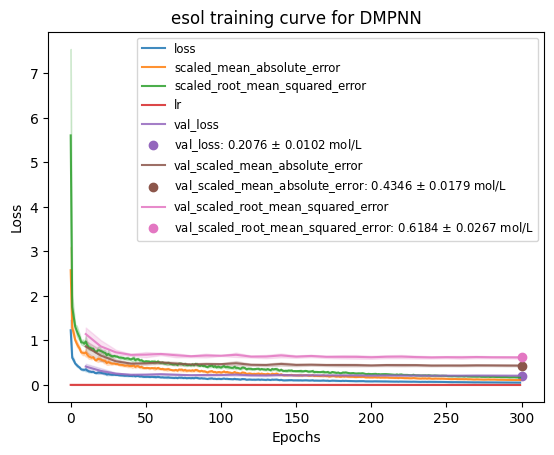

In [14]:
from kgcnn.utils.plots import plot_train_test_loss, plot_predict_true

plot_train_test_loss(history_list, loss_name=None, val_loss_name=None,
                     model_name="DMPNN", data_unit="mol/L", dataset_name="esol",
                     filepath="", file_name=f"loss.png");

8/8 [==============================] - 1s 12ms/step


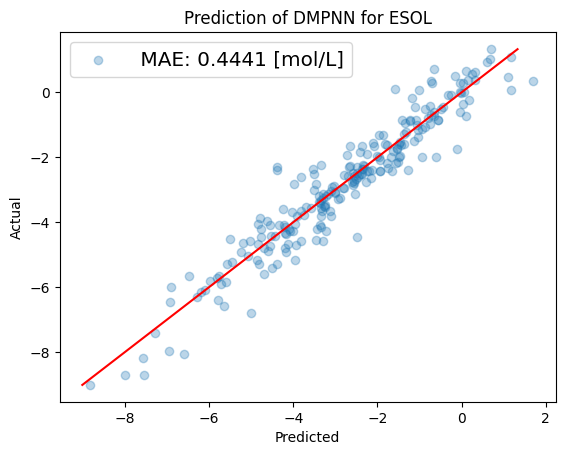

In [15]:
# Plot prediction for the last split.
predicted_y = model.predict(x_test)
true_y = y_test

# Predictions must be rescaled to original values.
predicted_y = scaler.inverse_transform(predicted_y)
true_y = scaler.inverse_transform(true_y)

# Plotting the prediction vs. true test targets for last split. Note for classification this is also done but
# can be ignored.
plot_predict_true(predicted_y, true_y,
                  filepath="", data_unit="mol/L",
                  model_name="DMPNN", dataset_name="ESOL",
                  file_name=f"predict.png");